In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import pandas as pd
sys.path.insert(0, str(Path.cwd().parent))


In [2]:
def repo_root_from_cwd() -> Path:
    p = Path.cwd().resolve()
    for q in (p, *p.parents):
        if (q / ".git").exists():          # best if present
            return q
        if (q / "pyproject.toml").exists(): # also good
            return q
        if (q / "dreamingnetz").is_dir():   # if that's your package dir
            return q
    raise RuntimeError("Could not locate repo root")

ROOT = repo_root_from_cwd()

In [3]:
import dreamingnetz.data_extraction as de

de.VALIDATION_LEVEL = "deep"     # optional
de.VALIDATION_MODE  = "strict"  # optional

In [4]:
from dreamingnetz.data_extraction import f

from dreamingnetz.pt_tau import (
    row_slice, betas_by_row, temps_by_row,
    tau_q01_t0, plot_tau_overlay_compare,
    compare_taus_from_roots, plot_compare_tau,
    save_compare, load_compare,
    tau_array, paired_log10_ratio, summarize_over_rids, frac_improved,plot_compare_tau_grid_2x2
)

run_root_1d = str((ROOT / "runs" / "prova2_edge_off_alpha04_N500_pool").resolve())
run_root_2d = str((ROOT / "runs" / "prova2_alpha04_N500_pool").resolve())


In [5]:
comp = compare_taus_from_roots(
    f,
    run_root_left=run_root_1d,
    run_root_right=run_root_2d,
    labels=("1D","2D"),
    b=4,
    burn=0.0,
    min_n=200,
    chain_reduce="none",

    # BM knobs (still used for certification)
    bm_min_batches=30,
    bm_rel_tol=0.10,
    bm_consec=2,

    # NEW: avoid NaNs when plateau missing
    bm_fail="last",          # or "max" (more conservative)
    # bm_fail="n",           # ultra-conservative: tau := n_used on failure

    # optional:
    # geyer_fail="n",
    compute_all_mu=True,
)

[tau_norm2] mu=0 (1/20)
[tau_norm2] mu=1 (2/20)
[tau_norm2] mu=2 (3/20)
[tau_norm2] mu=3 (4/20)
[tau_norm2] mu=4 (5/20)
[tau_norm2] mu=5 (6/20)
[tau_norm2] mu=6 (7/20)
[tau_norm2] mu=7 (8/20)
[tau_norm2] mu=8 (9/20)
[tau_norm2] mu=9 (10/20)
[tau_norm2] mu=10 (11/20)
[tau_norm2] mu=11 (12/20)
[tau_norm2] mu=12 (13/20)
[tau_norm2] mu=13 (14/20)
[tau_norm2] mu=14 (15/20)
[tau_norm2] mu=15 (16/20)
[tau_norm2] mu=16 (17/20)
[tau_norm2] mu=17 (18/20)
[tau_norm2] mu=18 (19/20)
[tau_norm2] mu=19 (20/20)
[tau_norm2] mu=0 (1/20)
[tau_norm2] mu=1 (2/20)
[tau_norm2] mu=2 (3/20)
[tau_norm2] mu=3 (4/20)
[tau_norm2] mu=4 (5/20)
[tau_norm2] mu=5 (6/20)
[tau_norm2] mu=6 (7/20)
[tau_norm2] mu=7 (8/20)
[tau_norm2] mu=8 (9/20)
[tau_norm2] mu=9 (10/20)
[tau_norm2] mu=10 (11/20)
[tau_norm2] mu=11 (12/20)
[tau_norm2] mu=12 (13/20)
[tau_norm2] mu=13 (14/20)
[tau_norm2] mu=14 (15/20)
[tau_norm2] mu=15 (16/20)
[tau_norm2] mu=16 (17/20)
[tau_norm2] mu=17 (18/20)
[tau_norm2] mu=18 (19/20)
[tau_norm2] mu=19 (20/20

In [7]:
save_compare(comp, ROOT/"analysis"/"tau_comp_1d_vs_2d_b4.pkl.gz")

PosixPath('/home/blazek_137/unipd/PMLS_project/analysis/tau_comp_1d_vs_2d_b4.pkl.gz')

In [5]:
# later / after restart:
comp = load_compare(ROOT/"analysis"/"tau_comp_1d_vs_2d_b0.pkl.gz")

In [ ]:
comp.right.m_mu0.tau_geyer.shape = (28, 2, 22)

(28, 2, 22)

In [6]:
# ---- reason codes (small, stable set) ----
GEYER = {
    "OK": 0,
    "SHORT": 1,
    "G0_NONPOS": 2,
    "M0_NO_POS_SEQ": 3,
    "TAU_NONFINITE": 4,
}
BM = {
    "OK": 0,
    "SHORT": 1,
    "G0_NONPOS": 2,
    "NO_VALID_BLOCKS": 3,
    "NO_PLATEAU": 4,
}

def _autocov_fft(y):
    y = np.asarray(y, float)
    y = y - np.mean(y)
    n = y.size
    # next pow2
    m = 1 << (2*n - 1).bit_length()
    fy = np.fft.rfft(y, n=m)
    ac = np.fft.irfft(fy*np.conjugate(fy), n=m)[:n]
    ac /= np.arange(n, 0, -1)  # unbiased-ish
    return ac

def _pava_decreasing(x):
    x = np.asarray(x, float).copy()
    # Pool adjacent violators for non-increasing constraint
    n = x.size
    w = np.ones(n)
    i = 0
    while i < n-1:
        if x[i] >= x[i+1]:
            i += 1
            continue
        # merge i and i+1
        s = x[i]*w[i] + x[i+1]*w[i+1]
        ww = w[i] + w[i+1]
        x[i] = s/ww
        w[i] = ww
        x = np.delete(x, i+1)
        w = np.delete(w, i+1)
        n -= 1
        if i > 0:
            i -= 1
    # expand back (conservative: piecewise constant)
    # easiest: return the pooled values, caller only needs sum
    return x

def geyer_ims_debug(y):
    y = np.asarray(y, float).ravel()
    n = y.size
    if n < 4:
        return np.nan, GEYER["SHORT"], {"n": n}

    gamma = _autocov_fft(y)
    g0 = float(gamma[0])
    if not np.isfinite(g0) or g0 <= 0:
        return np.nan, GEYER["G0_NONPOS"], {"n": n, "g0": g0, "var": float(np.var(y))}

    max_k = (n - 1) // 2
    G = gamma[: 2*max_k + 2].reshape(-1, 2).sum(axis=1)

    m = 0
    for k in range(G.size):
        if G[k] <= 0.0:
            break
        m = k + 1
    if m == 0:
        return np.nan, GEYER["M0_NO_POS_SEQ"], {"n": n, "g0": g0, "G0": float(G[0])}

    Gm = _pava_decreasing(G[:m])
    tau = -1.0 + (2.0 / g0) * float(np.sum(Gm))
    if not np.isfinite(tau):
        return np.nan, GEYER["TAU_NONFINITE"], {"n": n, "g0": g0, "m": m}
    if tau < 1.0:
        tau = 1.0
    return float(tau), GEYER["OK"], {"n": n, "g0": g0, "m": m}

def bm_plateau_debug(y, *, min_batches=30, rel_tol=0.10, consec=2):
    y = np.asarray(y, float).ravel()
    n = y.size
    if n < 8:
        return np.nan, BM["SHORT"], {"n": n}

    gamma0 = float(np.var(y, ddof=1))
    if not np.isfinite(gamma0) or gamma0 <= 0:
        return np.nan, BM["G0_NONPOS"], {"n": n, "var": gamma0}

    bs = []
    b = 1
    while b <= n // min_batches:
        bs.append(b)
        b *= 2

    valid_bs = []
    tau_hats = []
    for b in bs:
        a = n // b
        if a < min_batches:
            continue
        n_use = a * b
        bm = y[:n_use].reshape(a, b).mean(axis=1)
        s2 = float(np.var(bm, ddof=1))
        if not np.isfinite(s2) or s2 <= 0:
            continue
        tau = (b * s2) / gamma0
        if np.isfinite(tau) and tau >= 1.0:
            valid_bs.append(b)
            tau_hats.append(float(tau))

    if len(tau_hats) == 0:
        return np.nan, BM["NO_VALID_BLOCKS"], {"n": n, "var": gamma0, "n_valid": 0}

    if len(tau_hats) < consec + 1:
        return np.nan, BM["NO_PLATEAU"], {"n": n, "var": gamma0, "n_valid": len(tau_hats)}

    tau_hats = np.asarray(tau_hats, float)
    valid_bs = np.asarray(valid_bs, int)
    rel = np.abs(np.diff(tau_hats)) / np.maximum(tau_hats[:-1], 1e-12)

    for i in range(len(rel) - (consec - 1)):
        if np.all(rel[i:i+consec] <= rel_tol):
            return float(tau_hats[i+consec]), BM["OK"], {
                "n": n, "var": gamma0, "b_chosen": int(valid_bs[i+consec]), "n_valid": len(tau_hats)
            }
    return np.nan, BM["NO_PLATEAU"], {"n": n, "var": gamma0, "n_valid": len(tau_hats)}


In [7]:
from dreamingnetz.pt_tau import tau_array

def diagnose_q01_nans(f, run_root, comp, *, side="left", estimator="bm",
                      b=0, burn=0.0, cold_T=0.2, max_cases=200,
                      bm_min_batches=30, bm_rel_tol=0.10, bm_consec=2):
    taugrid = getattr(comp.left if side=="left" else comp.right, "q01")
    tau = tau_array(taugrid, estimator)  # (n_rid,K)
    T = np.asarray(comp.T_row)
    cold = T < cold_T

    # indices (rid,k) where tau is NaN in cold region
    idx = np.argwhere(~np.isfinite(tau[:, cold]))
    # map cold-k index -> k
    cold_ks = np.where(cold)[0]
    idx = idx[:max_cases]
    if idx.size == 0:
        return pd.DataFrame()

    meta = f(run_root, "meta")[0]
    k_start = np.asarray(meta.k_start)
    r0, r1 = (k_start[b], k_start[b+1])  # row slice
    q01_all = f(run_root, "q01")         # (n_rid,T,R)

    rows = []
    for rid, j in idx:
        k = int(cold_ks[int(j)])
        r = int(r0 + k)
        y = np.asarray(q01_all[rid, :, r], float)

        # apply burn like pt_tau does (float fraction or int)
        n0 = y.size
        bb = int(np.floor(burn*n0)) if isinstance(burn, float) else int(burn)
        y2 = y[bb:]

        if estimator == "geyer":
            tau_hat, code, info = geyer_ims_debug(y2)
            code_name = [k for k,v in GEYER.items() if v==code][0]
        else:
            tau_hat, code, info = bm_plateau_debug(y2, min_batches=bm_min_batches, rel_tol=bm_rel_tol, consec=bm_consec)
            code_name = [k for k,v in BM.items() if v==code][0]

        # simple stuckness stats
        dy = np.diff(y2)
        jump = np.mean(np.abs(dy) > 0) if dy.size else np.nan

        rows.append({
            "rid": int(rid), "k": k, "T": float(T[k]),
            "n": int(y2.size), "var": float(np.var(y2)) if y2.size else np.nan,
            "jump_rate": float(jump),
            "reason": code_name,
            "info": info,
        })
    return pd.DataFrame(rows)

df_q01_bm = diagnose_q01_nans(f, run_root_1d, comp, side="left", estimator="bm", cold_T=0.2,
                             bm_min_batches=30, bm_rel_tol=0.10, bm_consec=2)
df_q01_bm["reason"].value_counts()


def diagnose_mmu_nans(f, run_root, comp, *, mu=0, side="left", estimator="bm",
                      b=0, burn=0.0, cold_T=0.2, max_cases=200,
                      bm_min_batches=30, bm_rel_tol=0.10, bm_consec=2):
    taugrid = getattr(comp.left if side=="left" else comp.right, "m_mu0")
    tau = tau_array(taugrid, estimator)  # (n_rid,2,K) if chain_reduce="none", else (n_rid,K)
    T = np.asarray(comp.T_row)
    cold = T < cold_T
    cold_ks = np.where(cold)[0]

    meta = f(run_root, "meta")[0]
    k_start = np.asarray(meta.k_start)
    r0, r1 = (k_start[b], k_start[b+1])

    m = f(run_root, "m", mu=int(mu))  # (n_rid,2,T,R)

    rows = []
    if tau.ndim == 2:
        # treat as single series (already reduced)
        idx = np.argwhere(~np.isfinite(tau[:, cold]))[:max_cases]
        for rid, j in idx:
            k = int(cold_ks[int(j)])
            r = int(r0 + k)
            # pick chain 0 arbitrarily; you likely want chain_reduce="none" anyway
            y = np.asarray(m[rid, 0, :, r], float)
            n0 = y.size
            bb = int(np.floor(burn*n0)) if isinstance(burn, float) else int(burn)
            y2 = y[bb:]

            if estimator == "geyer":
                tau_hat, code, info = geyer_ims_debug(y2)
                code_name = [k for k,v in GEYER.items() if v==code][0]
            else:
                tau_hat, code, info = bm_plateau_debug(y2, min_batches=bm_min_batches, rel_tol=bm_rel_tol, consec=bm_consec)
                code_name = [k for k,v in BM.items() if v==code][0]

            dy = np.diff(y2)
            jump = np.mean(np.abs(dy) > 0) if dy.size else np.nan
            rows.append({"rid": int(rid), "chain": 0, "k": k, "T": float(T[k]),
                         "n": int(y2.size), "var": float(np.var(y2)) if y2.size else np.nan,
                         "jump_rate": float(jump), "reason": code_name, "info": info})
    else:
        # chain axis present
        idx = np.argwhere(~np.isfinite(tau[:, :, cold]))[:max_cases]  # (rid,chain,j)
        for rid, ch, j in idx:
            k = int(cold_ks[int(j)])
            r = int(r0 + k)
            y = np.asarray(m[rid, ch, :, r], float)
            n0 = y.size
            bb = int(np.floor(burn*n0)) if isinstance(burn, float) else int(burn)
            y2 = y[bb:]

            if estimator == "geyer":
                tau_hat, code, info = geyer_ims_debug(y2)
                code_name = [k for k,v in GEYER.items() if v==code][0]
            else:
                tau_hat, code, info = bm_plateau_debug(y2, min_batches=bm_min_batches, rel_tol=bm_rel_tol, consec=bm_consec)
                code_name = [k for k,v in BM.items() if v==code][0]

            dy = np.diff(y2)
            jump = np.mean(np.abs(dy) > 0) if dy.size else np.nan
            rows.append({"rid": int(rid), "chain": int(ch), "k": k, "T": float(T[k]),
                         "n": int(y2.size), "var": float(np.var(y2)) if y2.size else np.nan,
                         "jump_rate": float(jump), "reason": code_name, "info": info})
    return pd.DataFrame(rows)

df_m0_bm = diagnose_mmu_nans(f, run_root_1d, comp, mu=0, side="left", estimator="bm", cold_T=0.2,
                            bm_min_batches=30, bm_rel_tol=0.10, bm_consec=2)
df_m0_bm["reason"].value_counts()


KeyError: 'reason'

In [13]:
import numpy as np
import pandas as pd

from dreamingnetz.pt_tau import (
    tau_array, ok_array, paired_log10_ratio, summarize_over_rids,
    plot_compare_tau, plot_tau_overlay_compare
)

def frac_improved_paired(L, R, axis=0):
    """Fraction with R < L, conditioning on finite paired values."""
    L = np.asarray(L, float)
    R = np.asarray(R, float)
    mask = np.isfinite(L) & np.isfinite(R)
    num = np.sum((R < L) & mask, axis=axis)
    den = np.sum(mask, axis=axis)
    out = np.full_like(num, np.nan, dtype=float)
    return np.divide(num, den, out=out, where=(den > 0))

def _get_taugrid(comp, obs, side):
    """Return TauGrid (or TauMuGrid for m_all_mu) from comp.left/right."""
    run = comp.left if side == "left" else comp.right
    g = getattr(run, obs)
    if g is None:
        raise ValueError(f"Observable {obs} is None on {side}. Was it computed?")
    return g

def _reduce_mu(tau_mu, *, mode="max"):
    """
    tau_mu: (n_rid, Kb, n_mu) float with NaNs allowed
    returns: (n_rid, Kb)
    """
    if mode == "max":
        return np.nanmax(tau_mu, axis=-1)
    if mode == "mean":
        return np.nanmean(tau_mu, axis=-1)
    if mode == "median":
        return np.nanmedian(tau_mu, axis=-1)
    raise ValueError(f"unknown mode={mode}")

def _reduce_mu_ok(ok_mu, *, mode="all"):
    """
    ok_mu: (n_rid, Kb, n_mu) bool
    returns: (n_rid, Kb) bool  (or float if mode='frac')
    """
    if mode == "all":
        return np.all(ok_mu, axis=-1)
    if mode == "any":
        return np.any(ok_mu, axis=-1)
    if mode == "frac":
        return np.mean(ok_mu, axis=-1)  # float in [0,1]
    raise ValueError(f"unknown mode={mode}")

def extract_tau_ok(comp, obs, estimator, *, mu_tau_mode="max", mu_ok_mode="all"):
    """
    Returns:
      L_tau, R_tau : (n_rid, Kb) OR (n_rid, 2, Kb) float
      L_ok,  R_ok  : same shape as L_tau/R_tau (bool or float if mu_ok_mode='frac')
      T_row        : (Kb,)
    """
    T_row = np.asarray(comp.T_row, float)

    if obs != "m_all_mu":
        Lg = _get_taugrid(comp, obs, "left")
        Rg = _get_taugrid(comp, obs, "right")
        L_tau = tau_array(Lg, estimator)
        R_tau = tau_array(Rg, estimator)
        L_ok = ok_array(Lg, estimator)
        R_ok = ok_array(Rg, estimator)
        return L_tau, R_tau, L_ok, R_ok, T_row

    # m_all_mu: TauMuGrid with arrays (..., Kb, n_mu) where ... is either (n_rid,) or (n_rid,2)
    Lg = _get_taugrid(comp, obs, "left")
    Rg = _get_taugrid(comp, obs, "right")

    L_tau_mu = Lg.tau_geyer if estimator == "geyer" else Lg.tau_bm
    R_tau_mu = Rg.tau_geyer if estimator == "geyer" else Rg.tau_bm
    L_ok_mu  = Lg.ok_geyer  if estimator == "geyer" else Lg.ok_bm
    R_ok_mu  = Rg.ok_geyer  if estimator == "geyer" else Rg.ok_bm

    L_tau = _reduce_mu(L_tau_mu, mode=mu_tau_mode)      # reduces last axis (mu)
    R_tau = _reduce_mu(R_tau_mu, mode=mu_tau_mode)
    L_ok  = _reduce_mu_ok(L_ok_mu, mode=mu_ok_mode)     # reduces last axis (mu)
    R_ok  = _reduce_mu_ok(R_ok_mu, mode=mu_ok_mode)
    return L_tau, R_tau, L_ok, R_ok, T_row


def test_suite(comp, obs, estimator, *, cold_T=0.2, q=0.10, mu_tau_mode="max", mu_ok_mode="all"):
    L_tau, R_tau, L_ok, R_ok, T_row = extract_tau_ok(
        comp, obs, estimator, mu_tau_mode=mu_tau_mode, mu_ok_mode=mu_ok_mode
    )
    cold_mask = (T_row < cold_T)

    # test_1: node-wise paired log10 ratio, summarized over rids (axis=0)
    log10_ratio = paired_log10_ratio(L_tau, R_tau)      # shape: (n_rid,K) or (n_rid,2,K)
    S_nodes = summarize_over_rids(log10_ratio, q=q, axis=0)  # -> (K) or (2,K)

    # test_2: win fraction per node (paired-finite conditioned), over rids
    win_nodes = frac_improved_paired(L_tau, R_tau, axis=0)   # -> (K) or (2,K)

    # test_3: ok fractions per node, over rids
    okL_nodes = (np.mean(L_ok, axis=0) if L_ok.dtype == bool else np.nanmean(L_ok, axis=0))
    okR_nodes = (np.mean(R_ok, axis=0) if R_ok.dtype == bool else np.nanmean(R_ok, axis=0))

    # cold-region aggregation: slice last axis
    cold_vals = log10_ratio[..., cold_mask].ravel()
    cold_med = np.nanmedian(cold_vals)
    cold_qlo = np.nanquantile(cold_vals, q)
    cold_qhi = np.nanquantile(cold_vals, 1.0 - q)

    # cold wins / cold finite-paired fraction
    Lc = L_tau[..., cold_mask]
    Rc = R_tau[..., cold_mask]
    mask = np.isfinite(Lc) & np.isfinite(Rc)
    cold_win = np.sum((Rc < Lc) & mask) / np.sum(mask) if np.sum(mask) > 0 else np.nan
    cold_finite = np.mean(mask)

    return dict(
        obs=obs,
        estimator=estimator,
        T_row=T_row,
        cold_mask=cold_mask,
        log10_ratio_summary=S_nodes,
        win_frac_nodes=win_nodes,
        ok_frac_left_nodes=okL_nodes,
        ok_frac_right_nodes=okR_nodes,
        cold_log10ratio_median=cold_med,
        cold_log10ratio_qlo=cold_qlo,
        cold_log10ratio_qhi=cold_qhi,
        cold_win_frac=cold_win,
        cold_pair_finite_frac=cold_finite,
    )


def both_estimators_win_nodes(comp, obs, *, cold_T=0.2, mu_tau_mode="max", mu_ok_mode="all"):
    wins = []
    masks = []

    for est in ["geyer", "bm"]:
        L_tau, R_tau, L_ok, R_ok, T_row = extract_tau_ok(
            comp, obs, est, mu_tau_mode=mu_tau_mode, mu_ok_mode=mu_ok_mode
        )
        finite = np.isfinite(L_tau) & np.isfinite(R_tau)
        ok = (L_ok.astype(bool) & R_ok.astype(bool)) if L_ok.dtype == bool else finite
        mask = finite & ok
        win = (R_tau < L_tau) & mask
        wins.append(win)
        masks.append(mask)

    win_and = wins[0] & wins[1]
    mask_and = masks[0] & masks[1]

    num = np.sum(win_and, axis=0)   # -> (K) or (2,K)
    den = np.sum(mask_and, axis=0)
    win_frac_nodes = np.divide(num, den, out=np.full_like(num, np.nan, dtype=float), where=(den > 0))

    cold_mask = (T_row < cold_T)
    num_c = np.sum(win_and[..., cold_mask])
    den_c = np.sum(mask_and[..., cold_mask])
    cold_win = (num_c / den_c) if den_c > 0 else np.nan

    return win_frac_nodes, cold_win, T_row


In [14]:
OBS_LIST = ["q01", "m_mu0", "m_norm2", "m_maxabs", "m_all_mu"]  # include m_all_mu only if you computed it
COLD_T = 0.2

rows = []
results = {}  # (obs, estimator) -> dict returned by test_suite

for obs in OBS_LIST:
    for est in ["geyer", "bm"]:
        try:
            r = test_suite(comp, obs, est, cold_T=COLD_T, q=0.10, mu_tau_mode="max", mu_ok_mode="all")
        except Exception as e:
            print(f"SKIP {obs}/{est}: {e}")
            continue

        results[(obs, est)] = r

        rows.append(dict(
            obs=obs,
            estimator=est,
            cold_T=f"<{COLD_T}",
            cold_log10ratio_median=r["cold_log10ratio_median"],
            cold_log10ratio_q10=r["cold_log10ratio_qlo"],
            cold_log10ratio_q90=r["cold_log10ratio_qhi"],
            cold_win_frac=r["cold_win_frac"],
            cold_pair_finite_frac=r["cold_pair_finite_frac"],
        ))

df_cold = pd.DataFrame(rows).sort_values(["obs", "estimator"])
df_cold


obs estimator cold_T  cold_log10ratio_median  cold_log10ratio_q10  \
9  m_all_mu        bm   <0.2                0.895482             0.508026   
8  m_all_mu     geyer   <0.2                0.753384             0.488173   
7  m_maxabs        bm   <0.2               -0.002817            -0.027267   
6  m_maxabs     geyer   <0.2                0.000000            -0.011181   
3     m_mu0        bm   <0.2                0.949181             0.439983   
2     m_mu0     geyer   <0.2                0.743308             0.354834   
5   m_norm2        bm   <0.2                0.003878            -0.031195   
4   m_norm2     geyer   <0.2                0.000586            -0.021117   
1       q01        bm   <0.2                0.063464             0.045387   
0       q01     geyer   <0.2                0.255403             0.185343   

   cold_log10ratio_q90  cold_win_frac  cold_pair_finite_frac  
9             1.679103       0.982143               1.000000  
8             1.835979       0.964286               1.000000  
7             0.016879       0.375000               1.000000  
6             0.015187       0.392857               1.000000  
3             1.690876       0.982143               1.000000  
2             1.741458       0.964286               1.000000  
5             1.158027       0.625000               1.000000  
4             1.202327       0.517857               1.000000  
1             0.269213       1.000000               0.571429  
0             2.647325       1.000000               1.000000

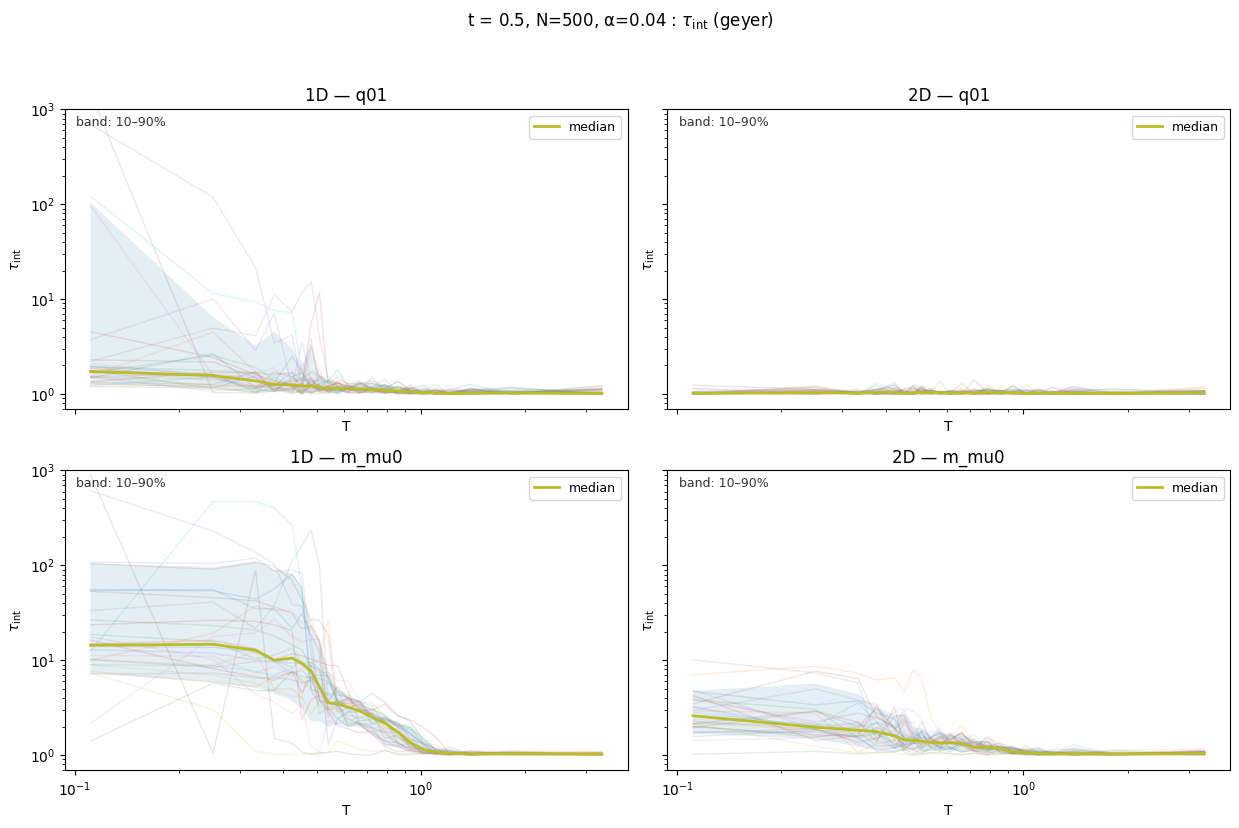

In [16]:
fig, axes = plot_compare_tau_grid_2x2(
    comp,
    obs_list=("q01", "m_mu0"),
    estimator="geyer",
    x_axis="T",
    log_x=True,
    yscale="log",
    q=0.10,
    ylim_by_obs={
        "q01": (0, 100),
        "m_mu0": (0, 1000),
    },
    suptitle=r"t = 0.5, N=500, α=0.04 : $\tau_{\mathrm{int}}$ (geyer)",
)


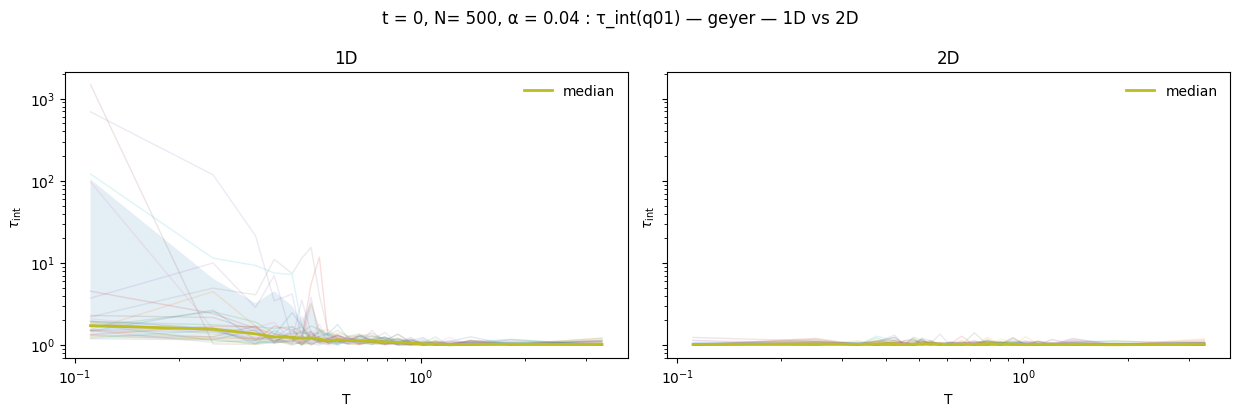

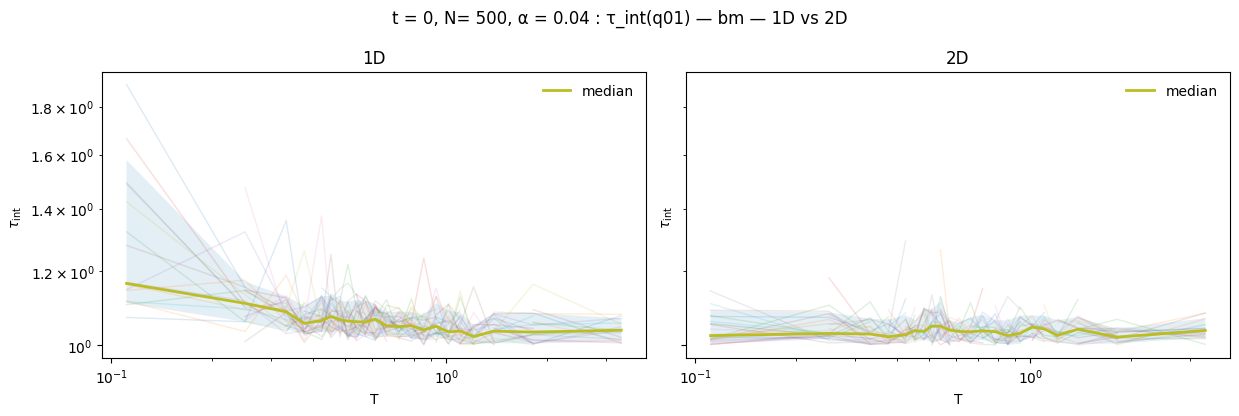

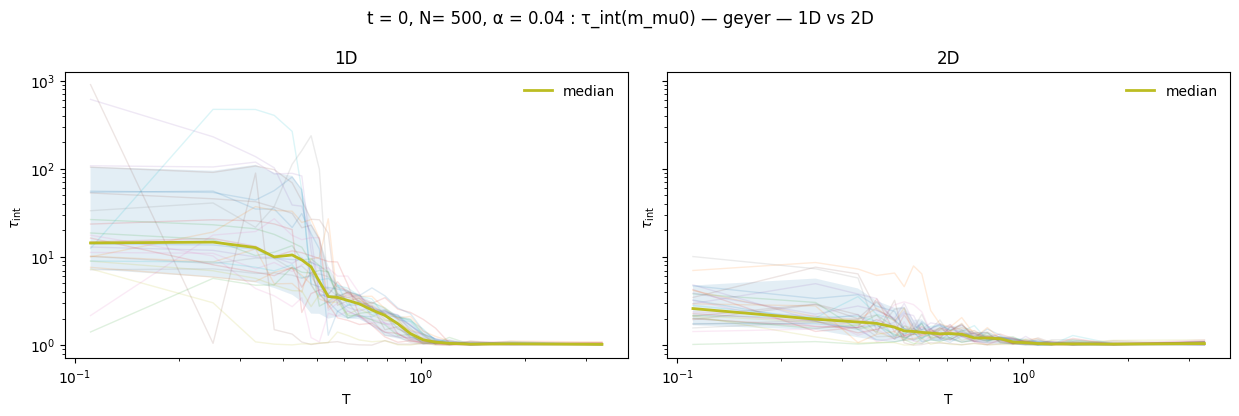

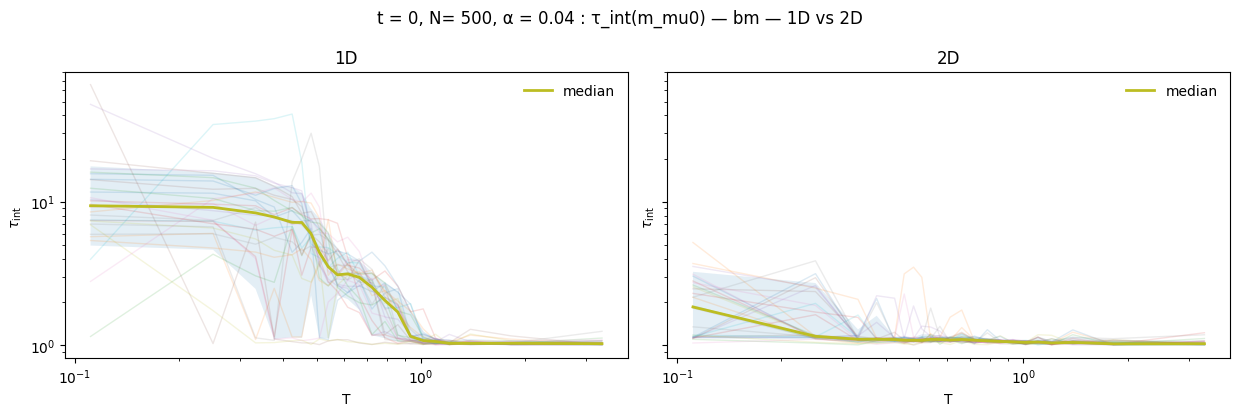

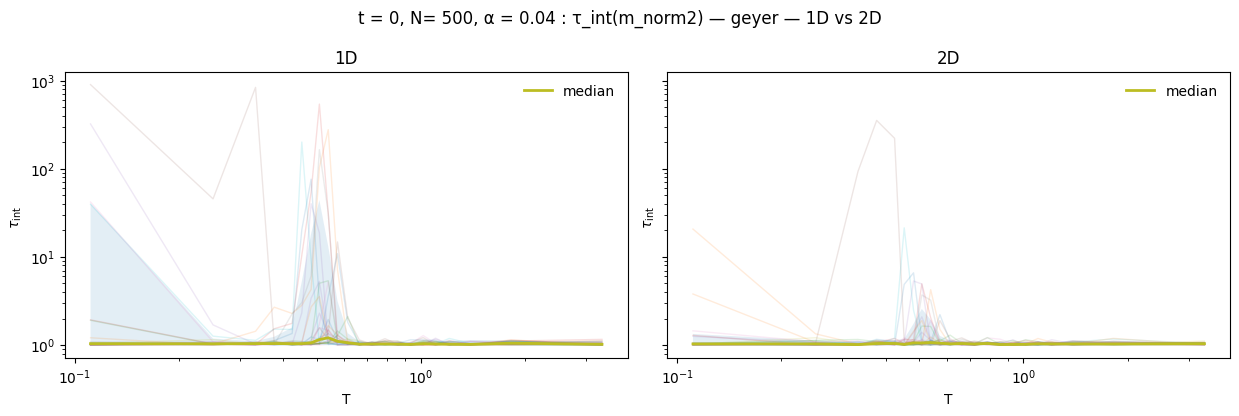

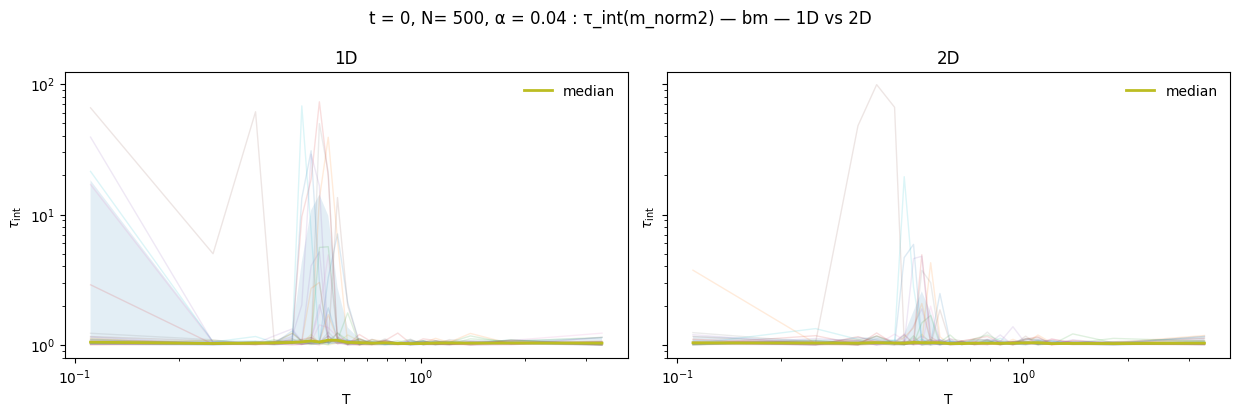

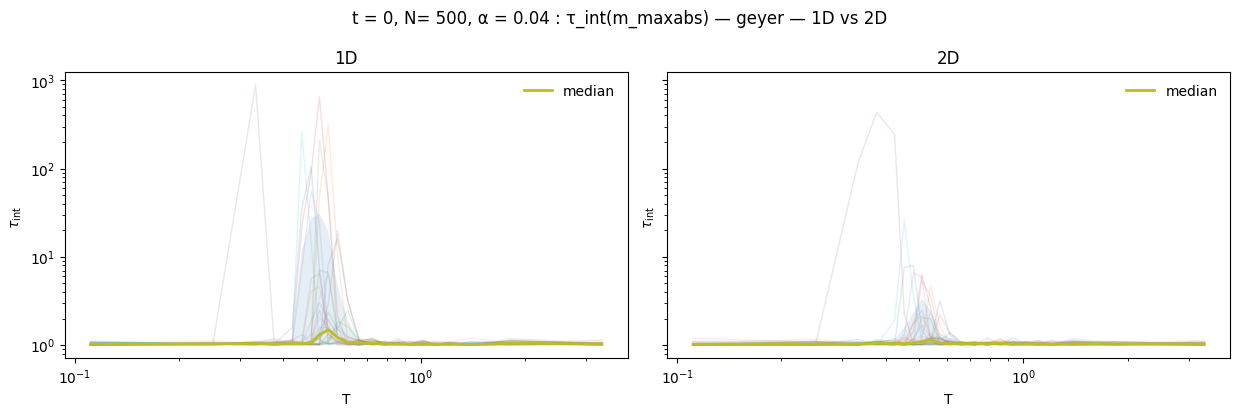

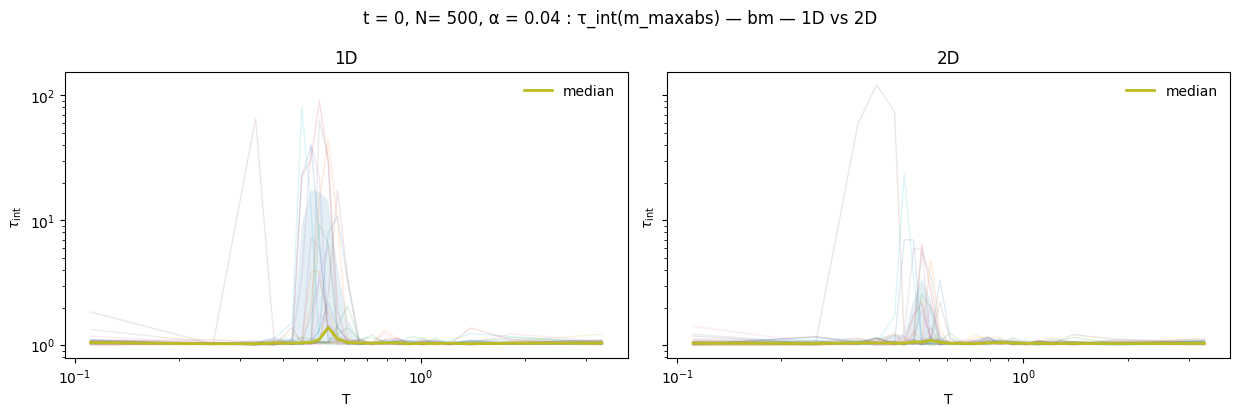

In [18]:
# For TauGrid observables, use plot_compare_tau.
for obs in ["q01", "m_mu0", "m_norm2", "m_maxabs"]:
    for est in ["geyer", "bm"]:
        try:
            plot_compare_tau(
                comp,
                obs=obs,
                estimator=est,
                x_axis="T",
                log_x=True,
                yscale="log",
                suptitle=f"t = 0, N= 500, α = 0.04 : τ_int({obs}) — {est} — 1D vs 2D",
            )
        except Exception as e:
            print(f"SKIP plot {obs}/{est}: {e}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_compare_tau_all_mu(comp, *, estimator="geyer", which_mu="all", x_axis="T", log_x=True, yscale="log"):
    # pick tau array
    Lg = _get_taugrid(comp, "m_all_mu", "left")
    Rg = _get_taugrid(comp, "m_all_mu", "right")
    tauL = Lg.tau_geyer if estimator == "geyer" else Lg.tau_bm
    tauR = Rg.tau_geyer if estimator == "geyer" else Rg.tau_bm

    T_row = np.asarray(comp.T_row, float)
    mu_list = getattr(comp, "mu_list", None)
    if mu_list is None:
        # fallback: try from grids
        mu_list = getattr(Lg, "mu_list", None)

    # choose which mu indices to plot
    n_mu = tauL.shape[-1]
    if which_mu == "all":
        mu_idx = range(n_mu)
    else:
        mu_idx = which_mu  # iterable of indices

    for i in mu_idx:
        # slice mu (keeps rid/chain/K dims)
        L = tauL[..., i]
        R = tauR[..., i]

        # reduce chain if present for "spaghetti" like your plot
        if L.ndim == 3:   # (rid, chain, K)
            Lp = np.nanmean(L, axis=1)
            Rp = np.nanmean(R, axis=1)
        else:             # (rid, K)
            Lp, Rp = L, R

        # spaghetti plot: per rid + median
        fig, ax = plt.subplots(1, 2, figsize=(12.5, 3.5), sharey=True)
        for rr in range(Lp.shape[0]):
            ax[0].plot(T_row, Lp[rr], alpha=0.25)
            ax[1].plot(T_row, Rp[rr], alpha=0.25)

        ax[0].plot(T_row, np.nanmedian(Lp, axis=0), lw=2, label="median")
        ax[1].plot(T_row, np.nanmedian(Rp, axis=0), lw=2, label="median")

        for a, title in zip(ax, ["1D", "2D"]):
            a.set_title(title)
            a.set_xlabel("T")
            a.set_ylabel(r"$\tau_{\mathrm{int}}$  ")
            if log_x: a.set_xscale("log")
            a.set_yscale(yscale)
            a.grid(True, alpha=0.2)
            a.legend()

        mu_label = mu_list[i] if mu_list is not None else i
        fig.suptitle(f"t=0: τ_int(m_mu={mu_label}) — {estimator} — 1D vs 2D")
        plt.show()


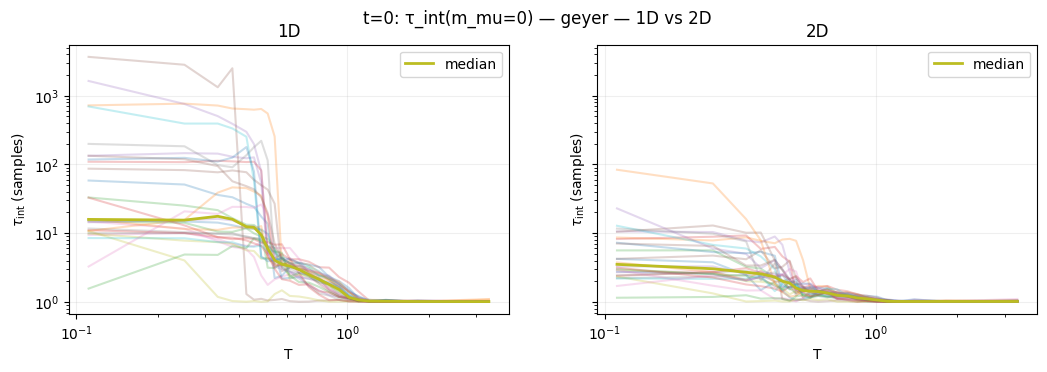

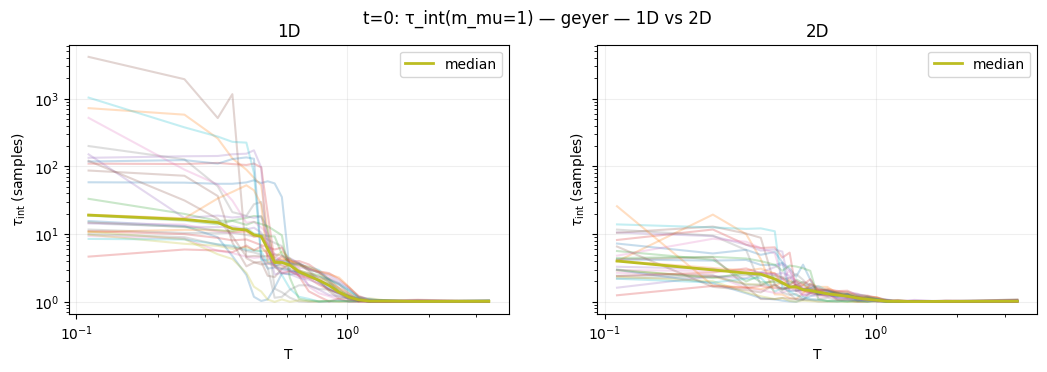

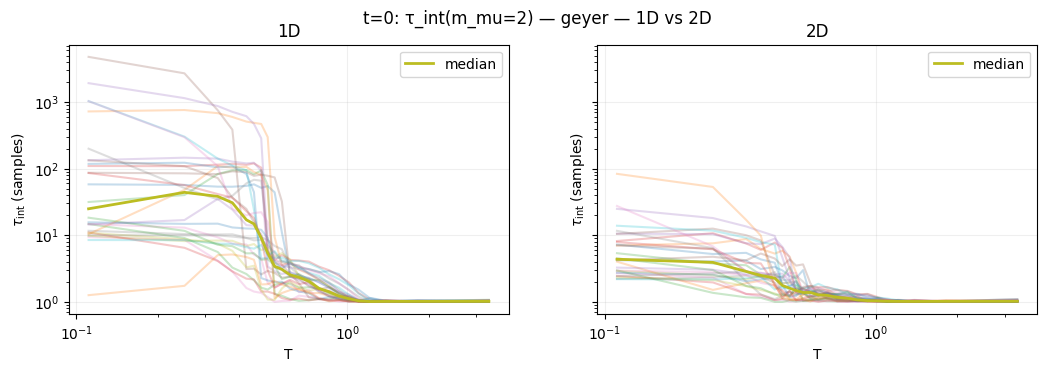

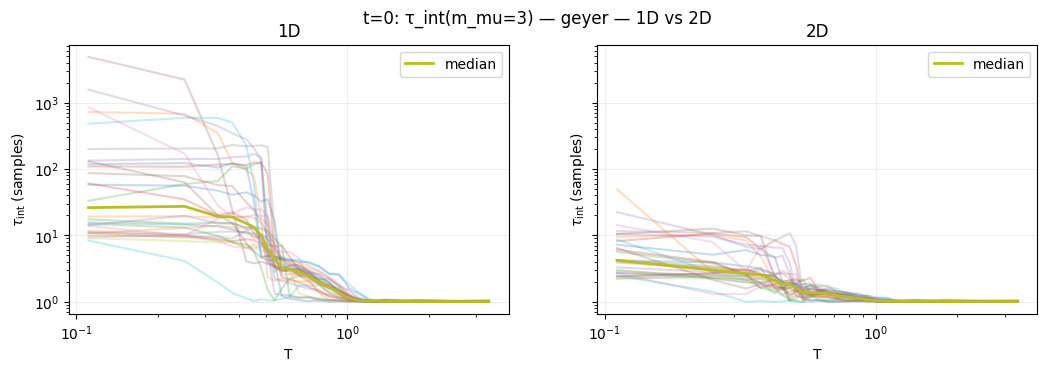

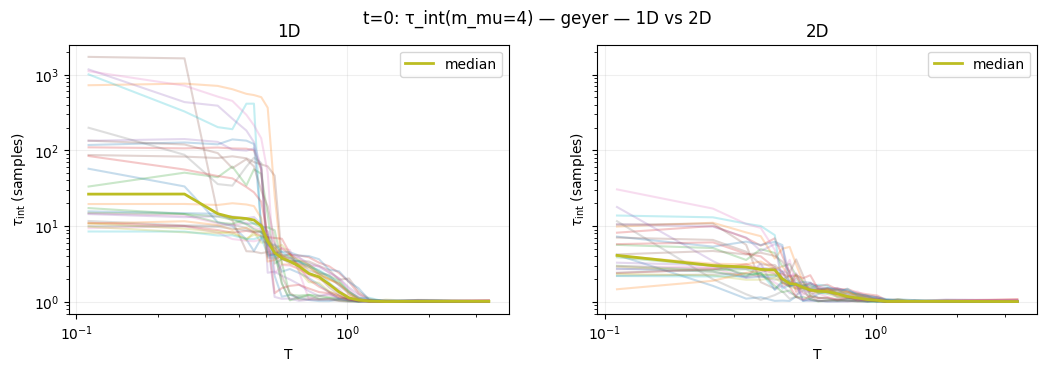

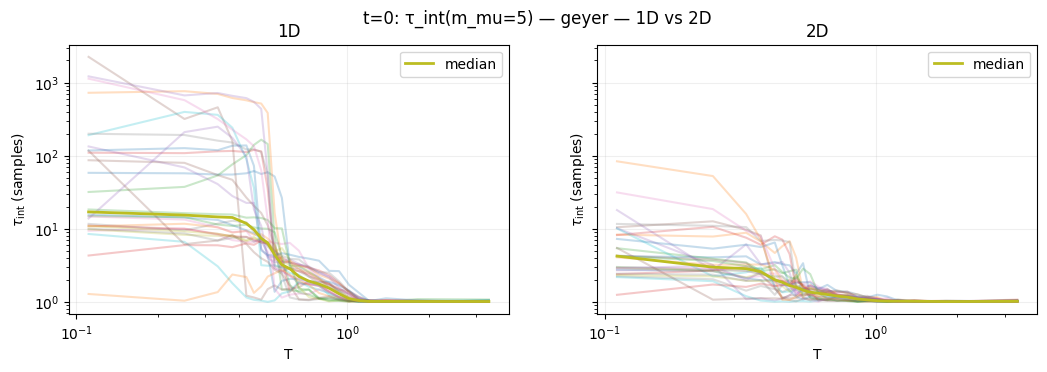

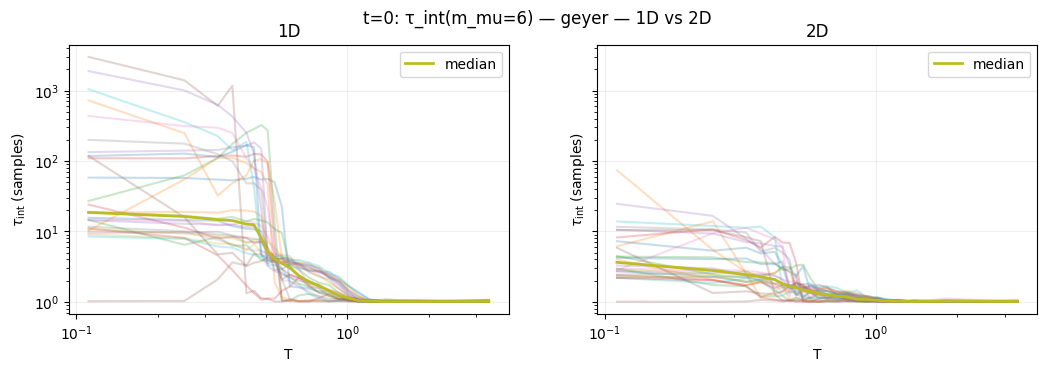

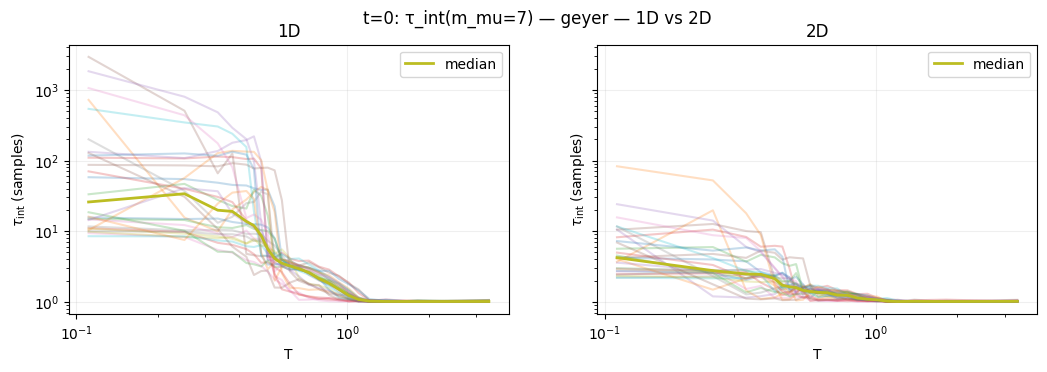

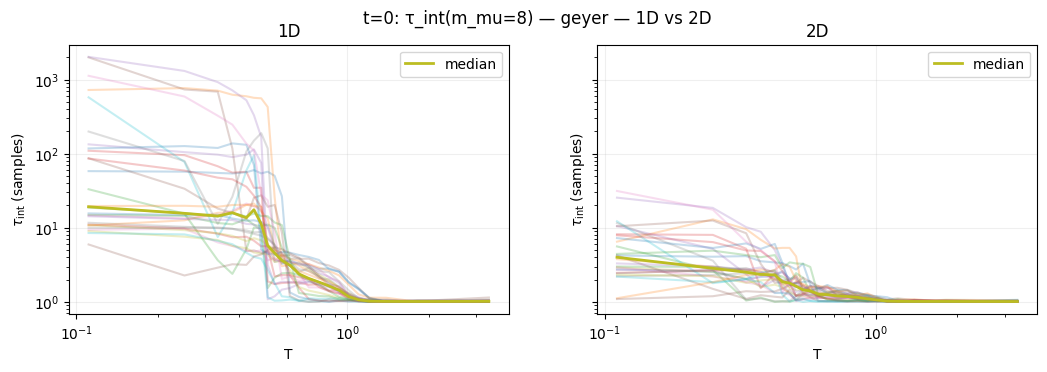

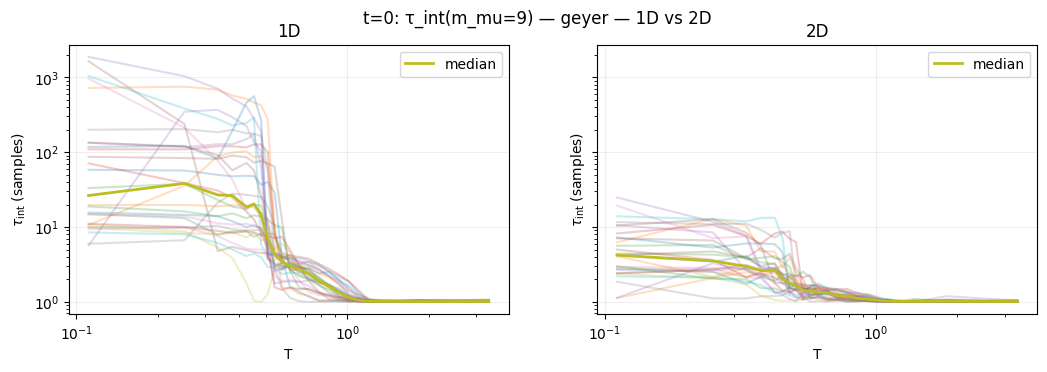

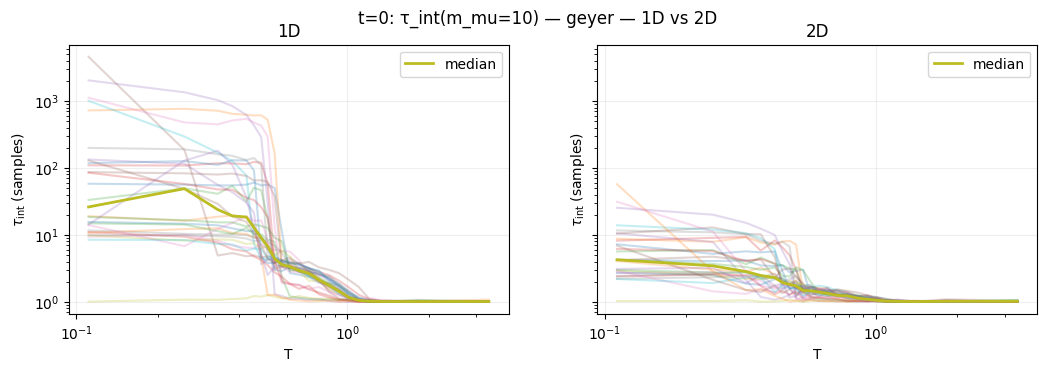

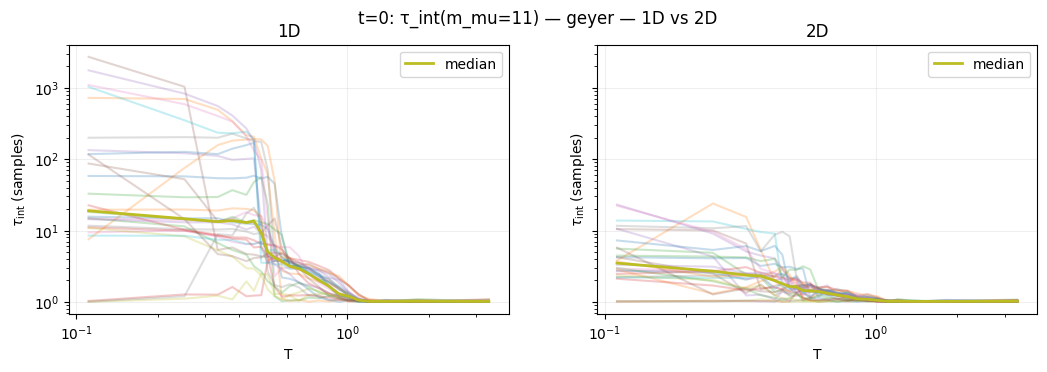

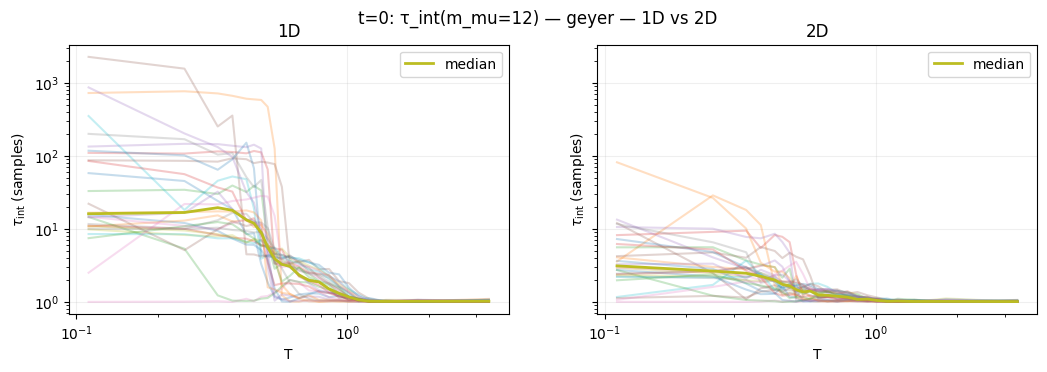

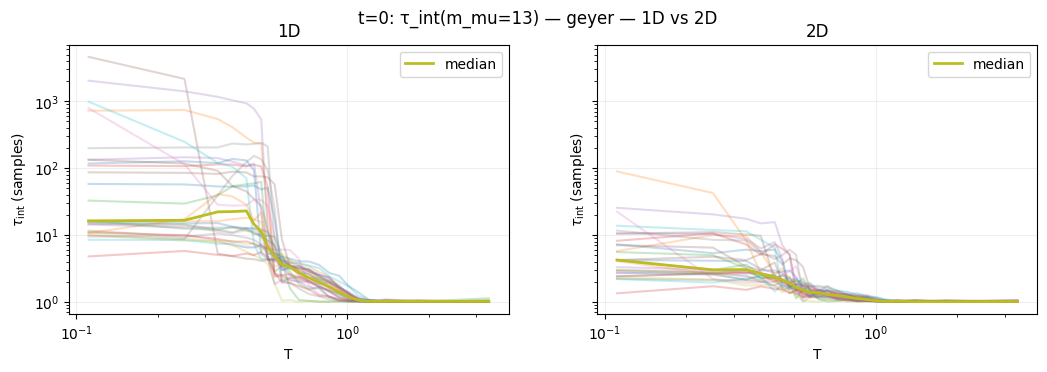

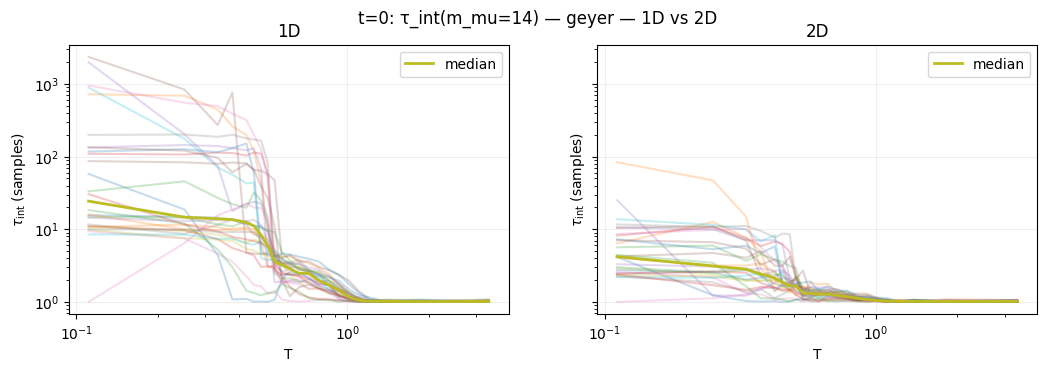

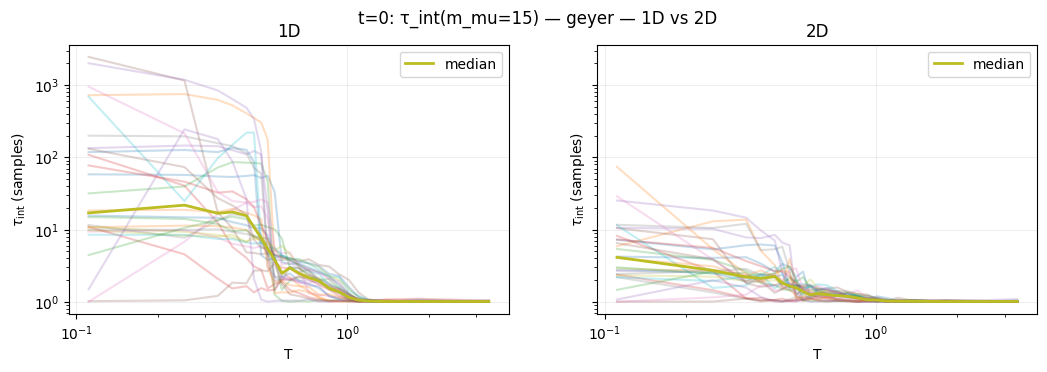

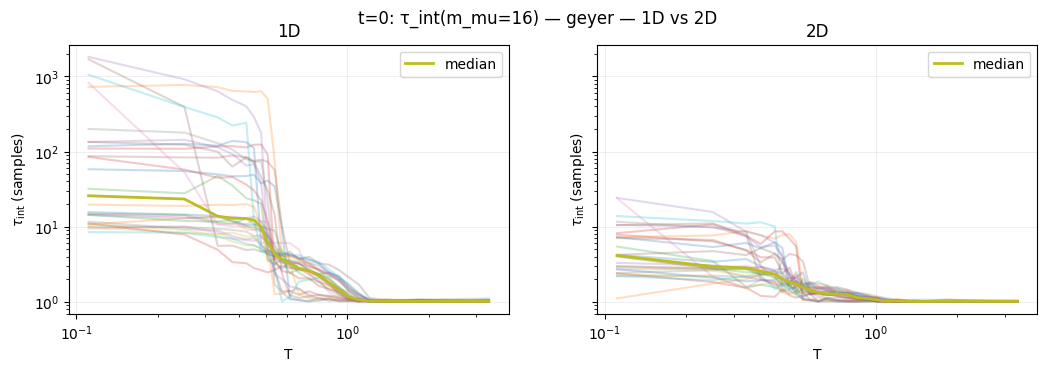

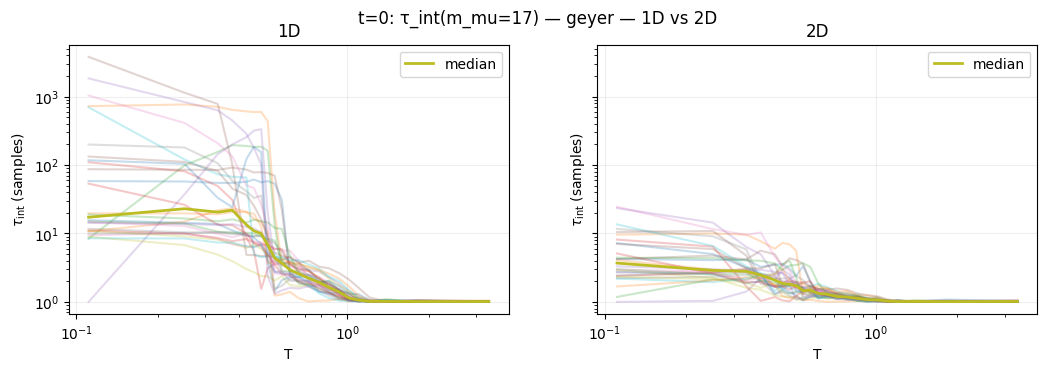

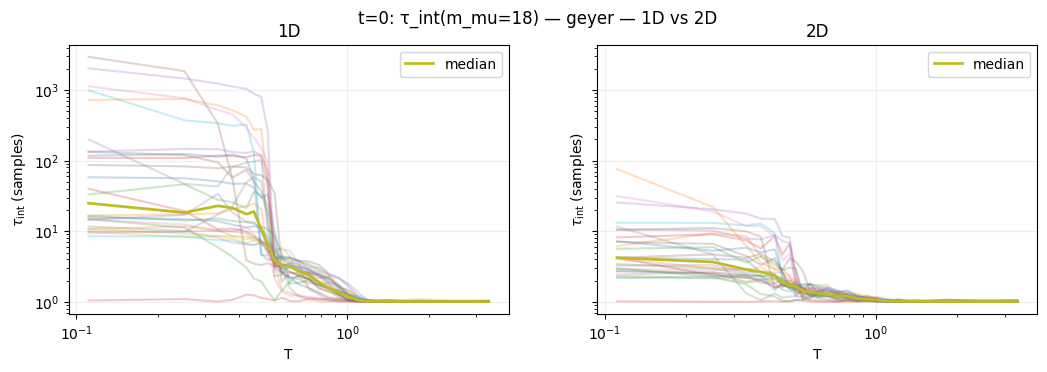

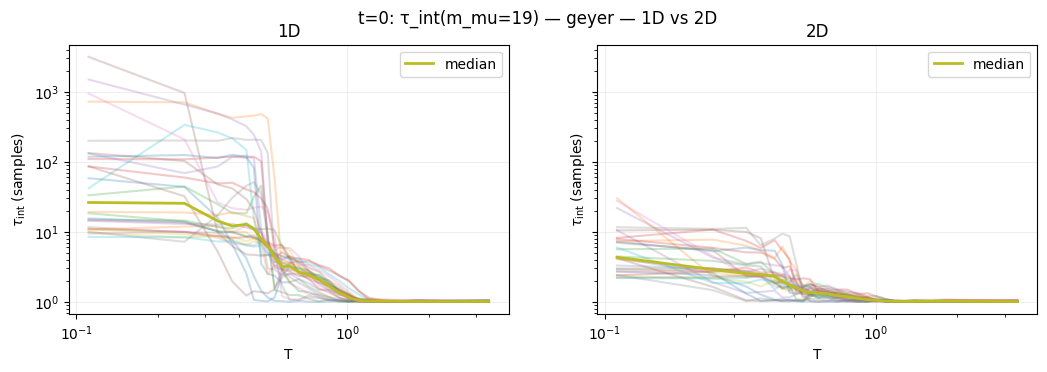

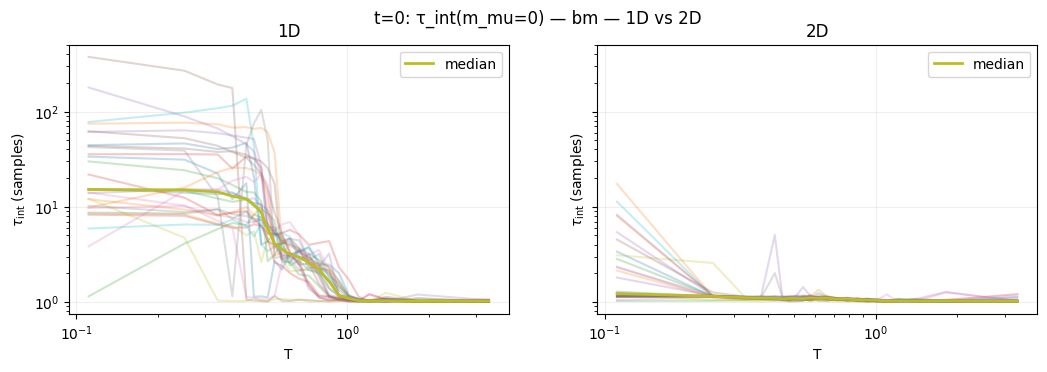

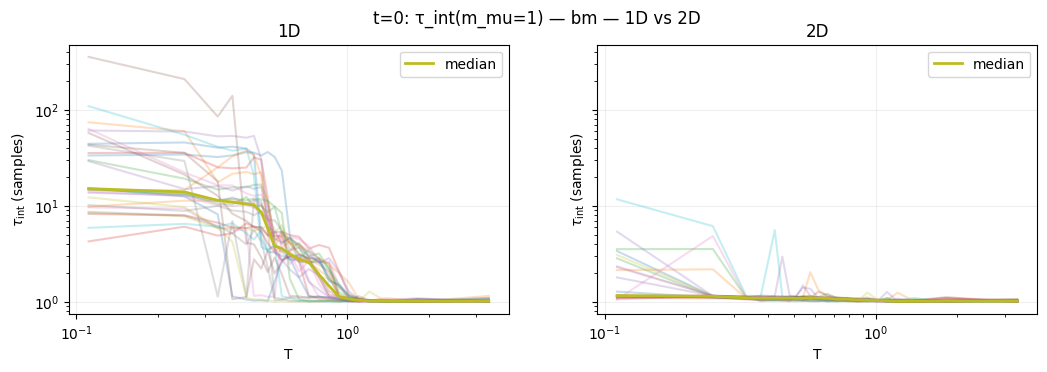

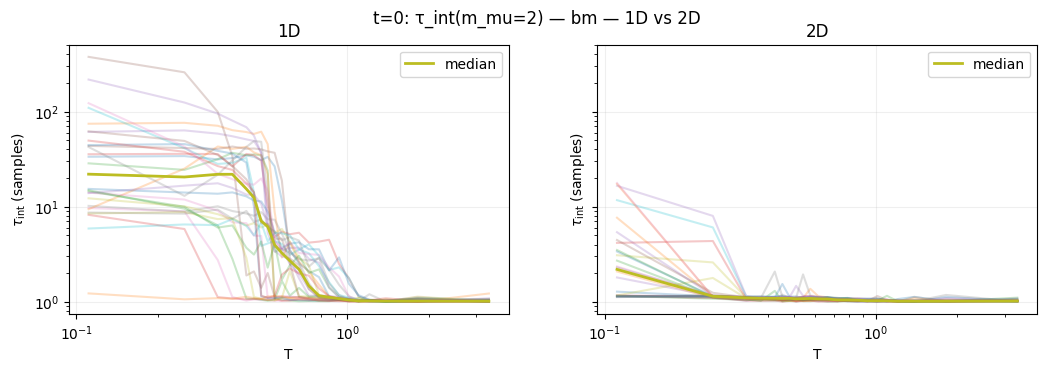

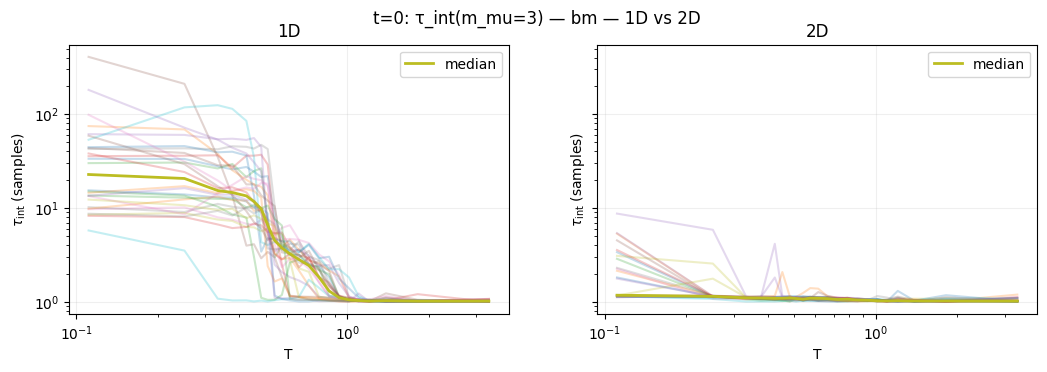

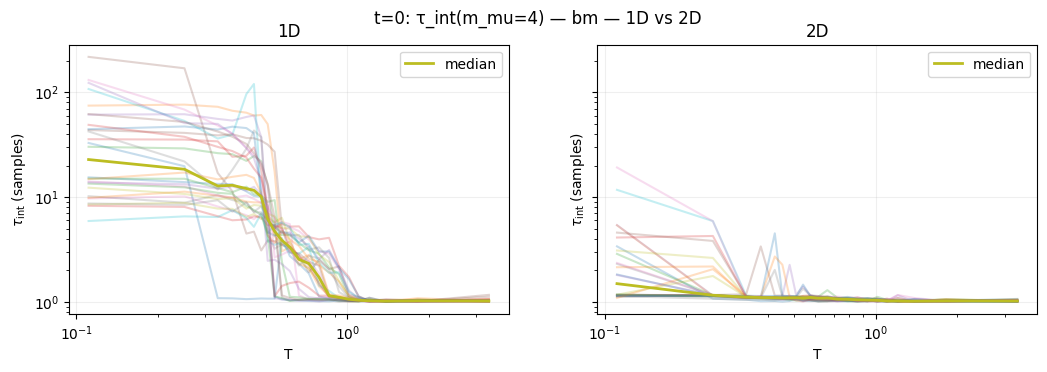

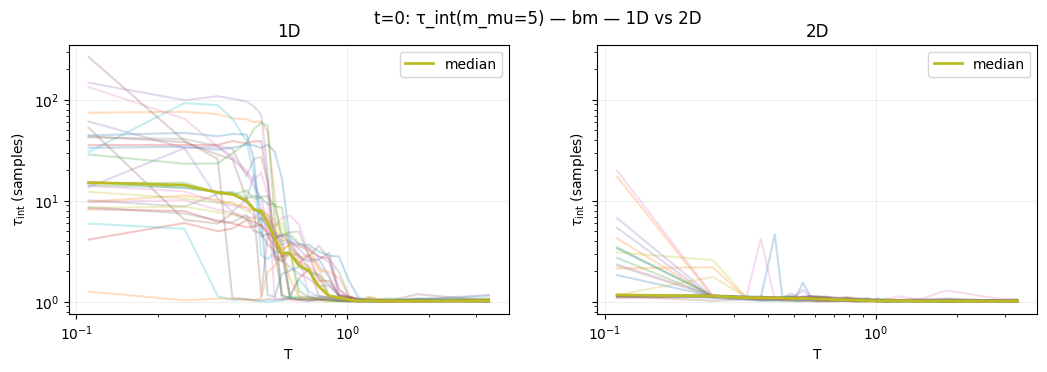

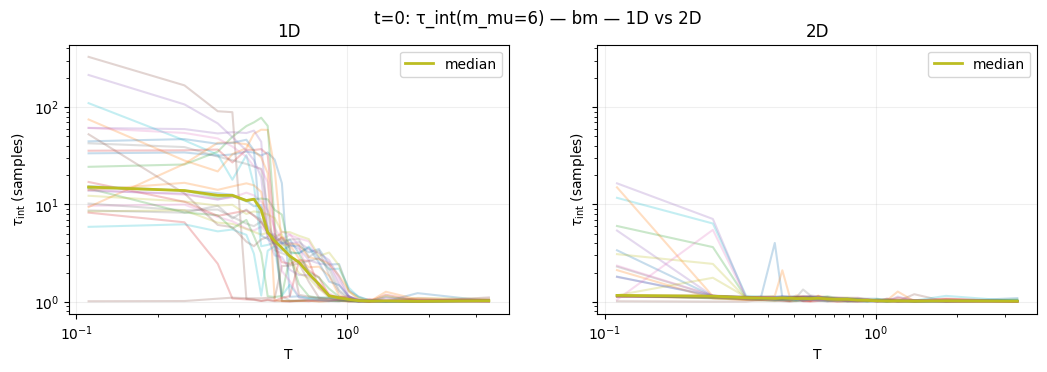

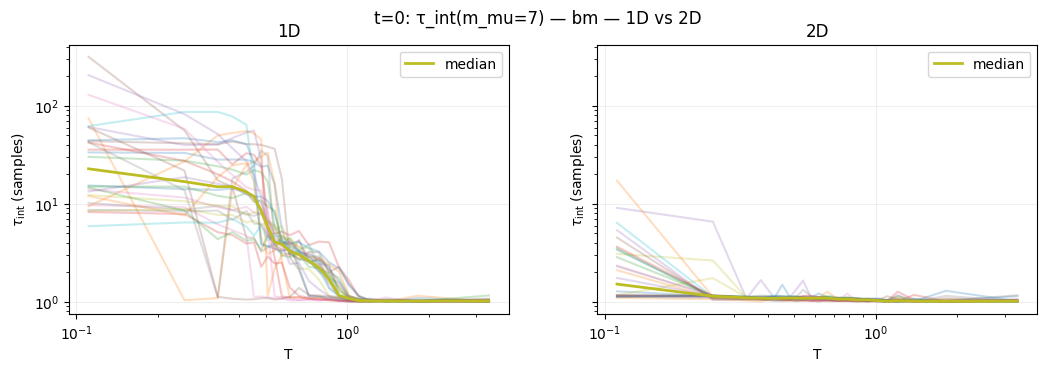

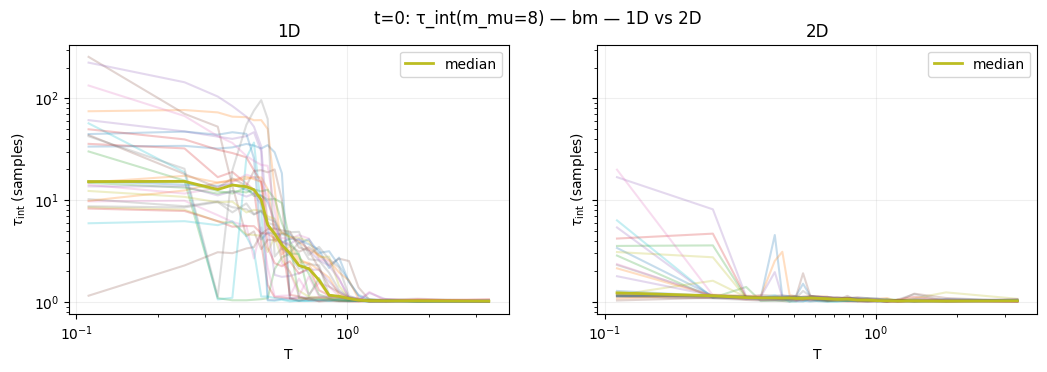

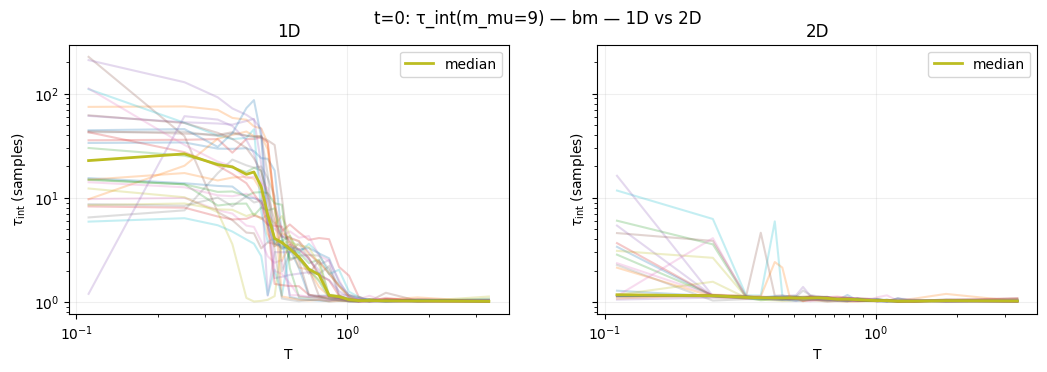

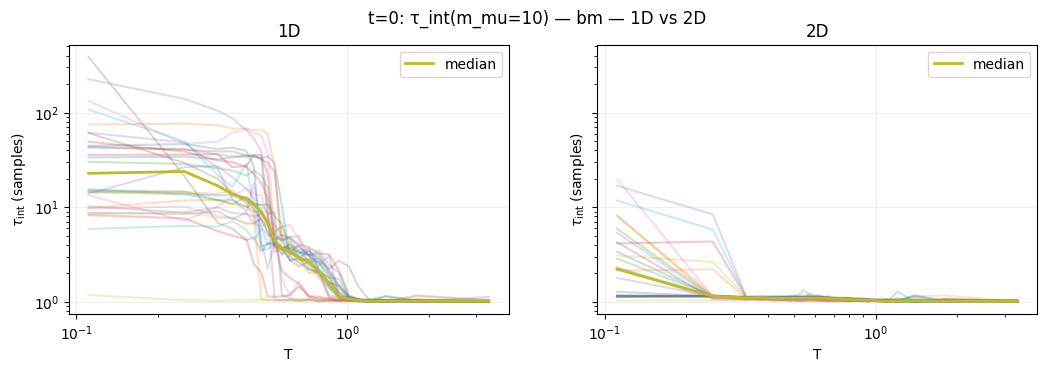

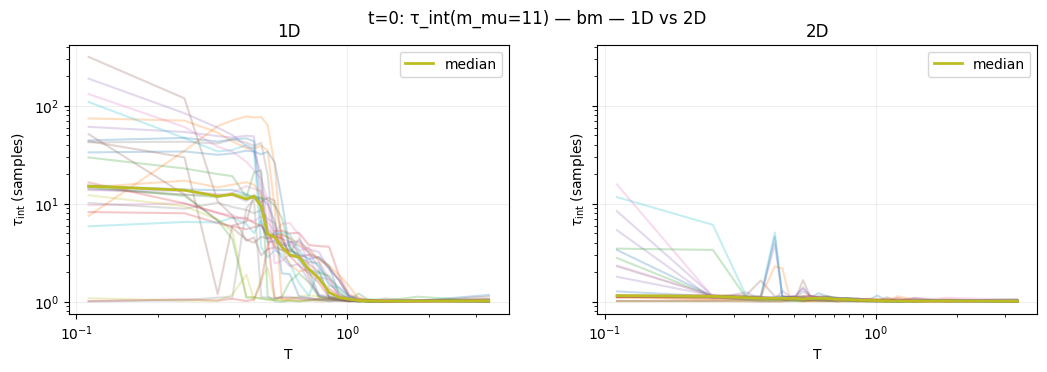

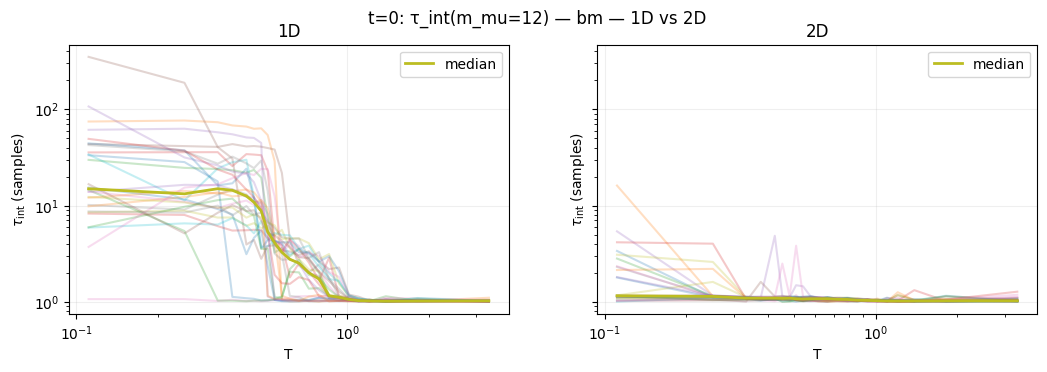

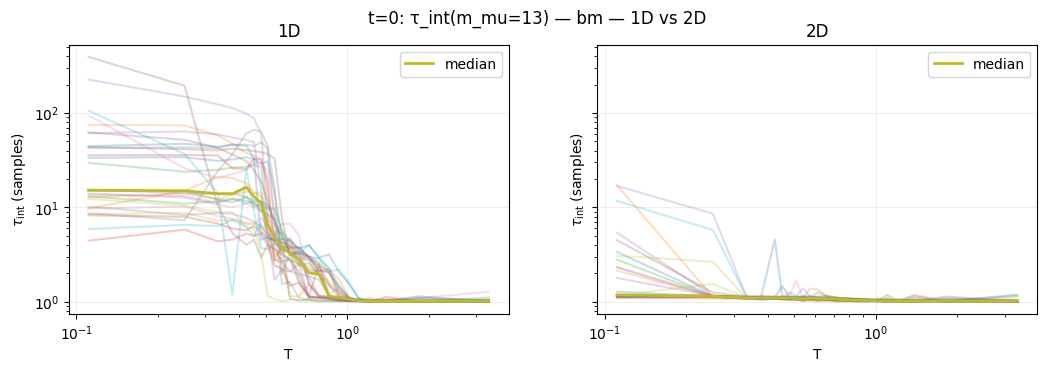

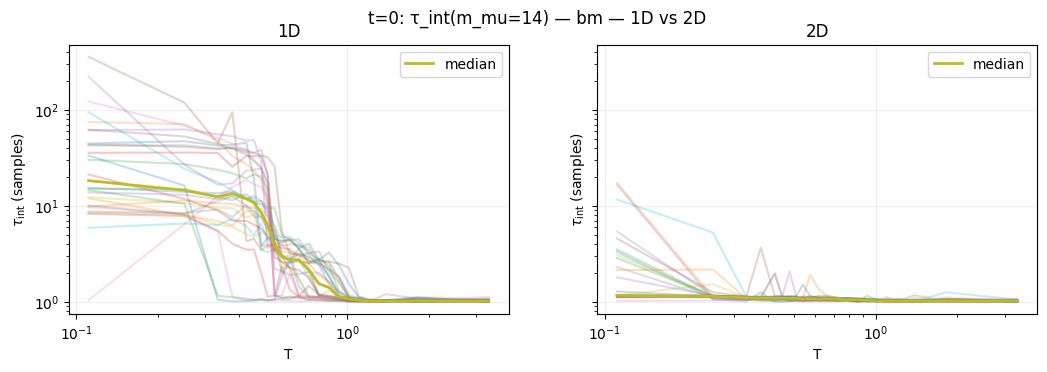

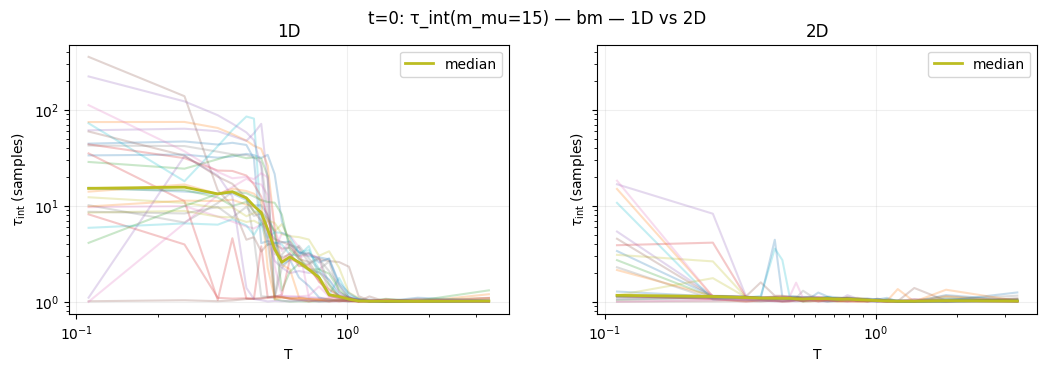

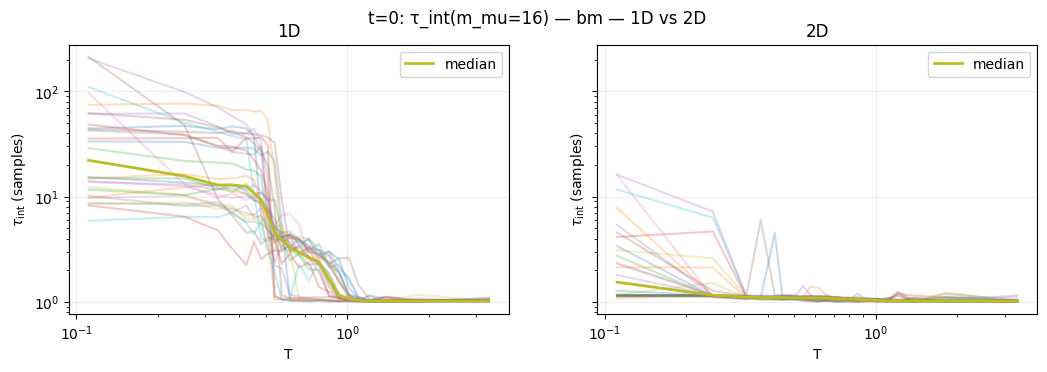

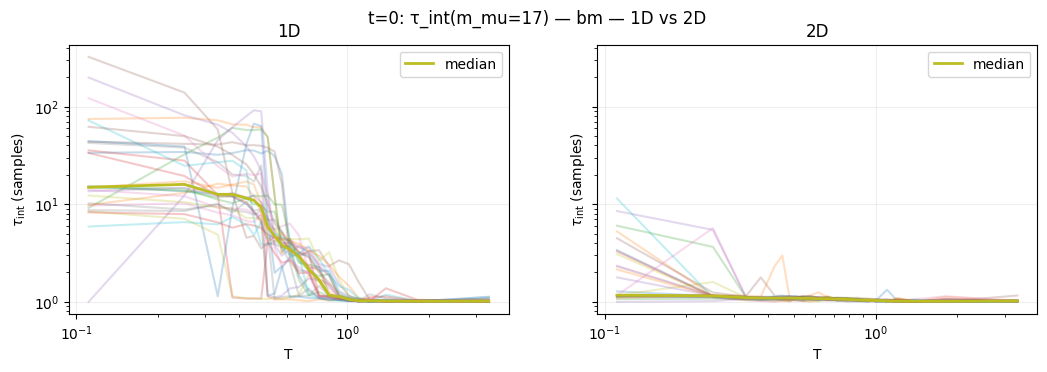

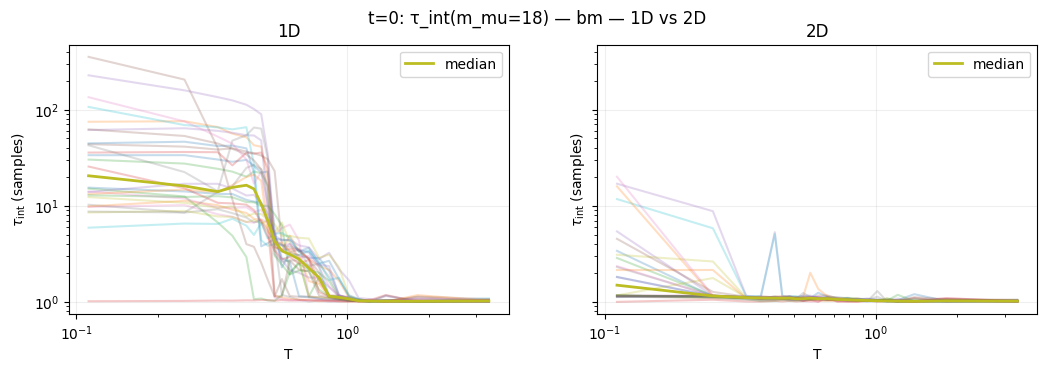

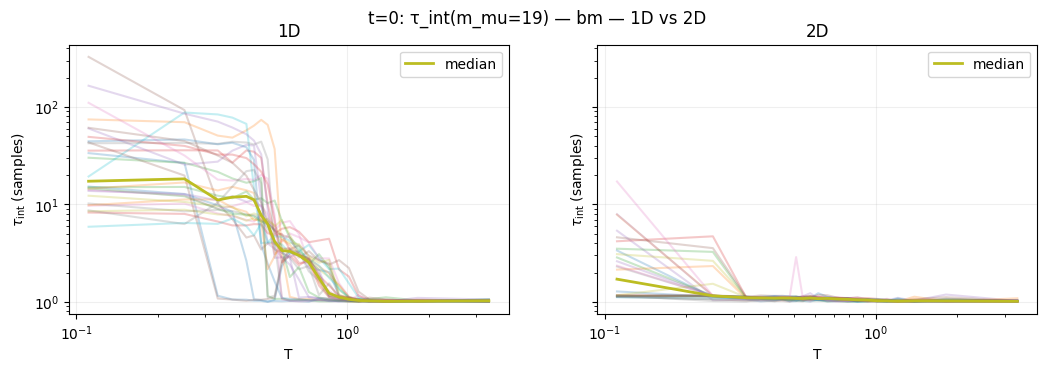

IndexError: index 20 is out of bounds for axis 3 with size 20

In [34]:
plot_compare_tau_all_mu(comp, estimator="geyer", which_mu="all")
# or just a subset
plot_compare_tau_all_mu(comp, estimator="bm", which_mu=range(28))


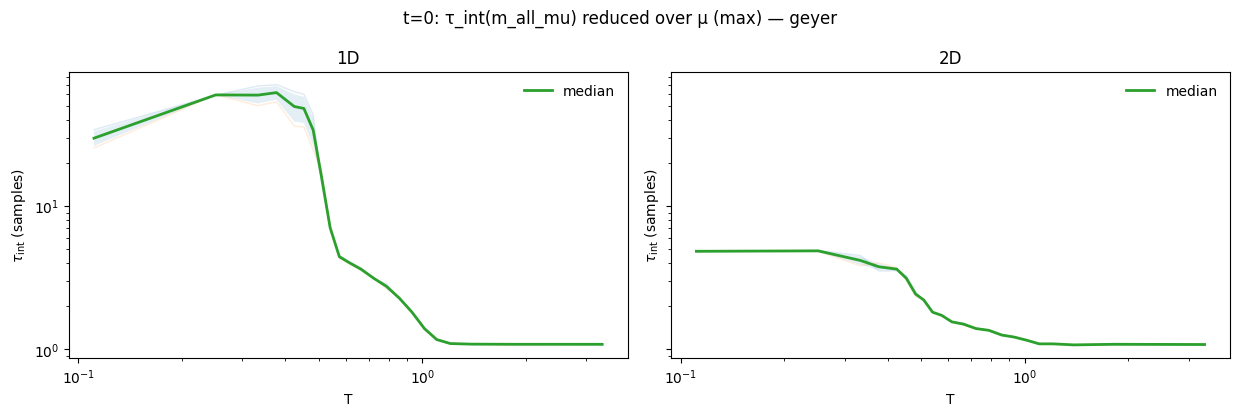

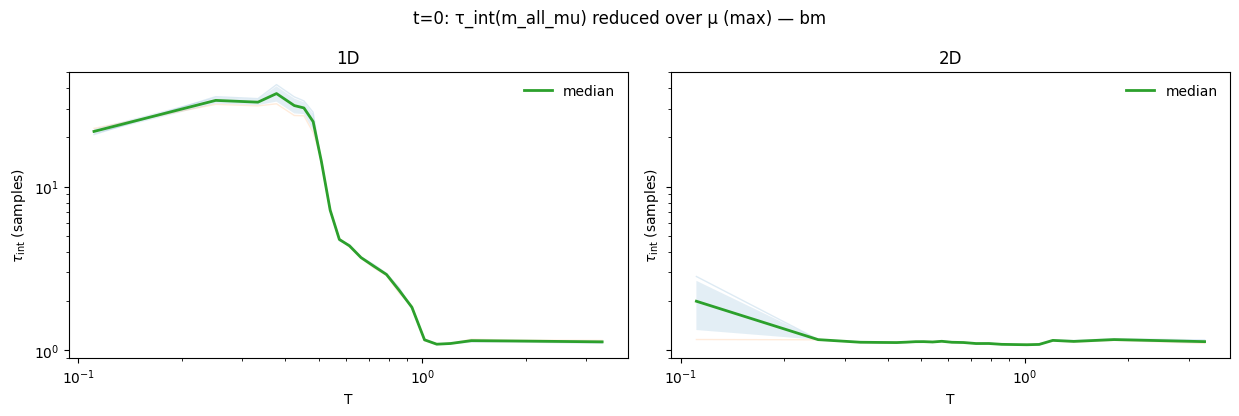

In [11]:
def plot_m_all_mu_reduced(comp, *, estimator="geyer", mu_tau_mode="max", log_x=True, yscale="log"):
    L_tau, R_tau, _, _, T_row = extract_tau_ok(comp, "m_all_mu", estimator, mu_tau_mode=mu_tau_mode, mu_ok_mode="all")
    # summarize over disorders: median τ per node (you can also add bands if you want)
    L_med = np.nanmedian(L_tau, axis=0)
    R_med = np.nanmedian(R_tau, axis=0)

    plot_tau_overlay_compare(
        T_row,
        L_med,
        R_med,
        labels=comp.labels,
        log_x=log_x,
        yscale=yscale,
        suptitle=f"t=0: τ_int(m_all_mu) reduced over μ ({mu_tau_mode}) — {estimator}",
        xlabel="T",
    )

for est in ["geyer", "bm"]:
    try:
        plot_m_all_mu_reduced(comp, estimator=est, mu_tau_mode="max")
    except Exception as e:
        print(f"SKIP m_all_mu plot {est}: {e}")


In [15]:
rows = []
for obs in OBS_LIST:
    try:
        win_nodes, cold_win, T_row = both_estimators_win_nodes(comp, obs, cold_T=COLD_T, mu_tau_mode="max", mu_ok_mode="all")
        rows.append(dict(obs=obs, both_estimators_cold_win_frac=cold_win))
    except Exception as e:
        print(f"SKIP both-est win {obs}: {e}")

pd.DataFrame(rows).sort_values("obs")


obs  both_estimators_cold_win_frac
4  m_all_mu                            NaN
3  m_maxabs                       0.156250
1     m_mu0                       1.000000
2   m_norm2                       0.230769
0       q01                       1.000000

In [28]:
cold_mask = (comp.T_row < 0.2)

tg = comp.left.m_mu0          # example observable on 2D side
ok = tg.ok_bm                  # or ok_geyer

ok_all = ok.mean()             # fraction OK over *all* entries
ok_cold = ok[..., cold_mask].mean()

In [29]:
ok_rid = ok[..., cold_mask].mean(axis=tuple(range(1, ok.ndim)))  # mean over everything except rid
# shape: (n_rid,)

In [30]:
ok_rid.sum()

np.float64(1.5)

In [31]:
ok_rid.sum()

np.float64(1.5)

In [32]:
tg = _get_taugrid(comp, "q01", "right")   # or "m_mu0", etc.
ok = tg.ok_geyer                         # shape (n_rid,K) or (n_rid,2,K)

fail_count = (~ok).sum()
ok_frac = ok.mean()
fail_count, ok_frac

(np.int64(0), np.float64(1.0))